In [1]:
#setting system path
import sys
sys.path.append('/home/tobias/Documents/TP/')
base_path = '/home/tobias/data/'

In [2]:
#loading some stuff 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from libs.ADL.libADL import adls

In [3]:
#now loading the pickle file containing the ADL data
with open(base_path + "LatestADL.pkl", "rb") as input_file:
    ADL = pickle.load(input_file)
print("Read ADL from pickle file")

Read ADL from pickle file


In [4]:
#got it that you need iteration to manipulate creation date
OK_hi_ids = []
cnt = 0
for hi_id, adl_hi in ADL.groupby('ADLRawData_HearingInstrumentId'):
    cnt = cnt + 1
    if (cnt % 1000 == 0):
        print('HI = ',cnt)
    
    #at least 10 ADL packages
    count_in_period = adl_hi[(adl_hi['ADLRawData_CreationTime']>'2019-04-01') & (adl_hi['ADLRawData_CreationTime'].max() > '2019-08-01') & (adl_hi['ADLRawData_CreationTime'].min()<'2019-02-01')].shape[0]

    if count_in_period > 10:
        OK_hi_ids.append(hi_id)
print("Found " + str(len(OK_hi_ids)) + " HI's with more than 10 ADL packages in period")


HI =  1000
HI =  2000
HI =  3000
HI =  4000
HI =  5000
HI =  6000
HI =  7000
HI =  8000
HI =  9000
HI =  10000
HI =  11000
HI =  12000
HI =  13000
HI =  14000
HI =  15000
HI =  16000
HI =  17000
HI =  18000
HI =  19000
HI =  20000
HI =  21000
HI =  22000
HI =  23000
HI =  24000
HI =  25000
HI =  26000
HI =  27000
HI =  28000
HI =  29000
HI =  30000
HI =  31000
HI =  32000
HI =  33000
HI =  34000
HI =  35000
HI =  36000
HI =  37000
HI =  38000
HI =  39000
HI =  40000
HI =  41000
HI =  42000
HI =  43000
HI =  44000
HI =  45000
HI =  46000
HI =  47000
HI =  48000
HI =  49000
HI =  50000
HI =  51000
HI =  52000
HI =  53000
HI =  54000
HI =  55000
HI =  56000
HI =  57000
HI =  58000
HI =  59000
HI =  60000
HI =  61000
HI =  62000
HI =  63000
HI =  64000
HI =  65000
HI =  66000
HI =  67000
HI =  68000
HI =  69000
HI =  70000
HI =  71000
HI =  72000
HI =  73000
HI =  74000
HI =  75000
HI =  76000
HI =  77000
HI =  78000
HI =  79000
HI =  80000
HI =  81000
HI =  82000
HI =  83000
HI =  84000
H

In [5]:
# Make subselection
sub_ADL = ADL[ADL['ADLRawData_HearingInstrumentId'].isin(OK_hi_ids)]

In [6]:
#now use ML classes
from libs.ADL.libADL import eq_delta_adls
from libs.ADL.libADL import adls

In [7]:
# Reset the index
sub_ADL = sub_ADL.set_index(np.arange(sub_ADL.shape[0]))
# Construct adls object
sub_adls = adls(sub_ADL)

Sorting ADL
Group by HI
Regroup by HI


In [64]:
hi_items = list(sub_adls.adl_by_hi.groups)
resampled_time_series={}
diff_time_series = {}
H1 = []
H2 = []
H = []
hi_use_time_low = []
hi_use_time_normal = []
hi_use_time_ano = []
hi_ = []

cnt = 0
for hi in hi_items:
    cnt = cnt + 1
    if (cnt % 1000 == 0):
        print("Searched " + str(cnt) + " ADLs")
    time_series = sub_adls.adl_by_hi.get_group(hi)
    time_series = time_series.set_index(pd.to_datetime(time_series['ADLRawData_CreationTime']))
    time_series = time_series.loc[~time_series.index.duplicated(keep='last')]
    time_series = time_series.sort_index()
        
    r_time_series = time_series['ADLProperties_TotalUseTime'].diff().resample('M').sum()
    bin = r_time_series==0
    if bin.iloc[-1]==True:
        continue
    for i in np.arange(r_time_series.shape[0]):
        start_row = i
        replace_rows = []
        n = 0
        #print("Start row : " + str(start_row))
        while (bin[start_row] == True):
            replace_rows.append(start_row)
            start_row = start_row + 1
            n = n + 1
            #print("Replace rows : " + str(replace_rows))
        if len(replace_rows) > 0:
            bin.iloc[replace_rows] = False            
            replace_value = r_time_series.iloc[start_row] / (n+1)
            r_time_series.iloc[replace_rows] = replace_value
            r_time_series.iloc[start_row] = replace_value

    resampled_time_series[hi]=r_time_series
   
    H1.append(r_time_series.loc['2019-01-01 00:00:00+00:00' \
                                :'2019-06-30 00:00:00+00:00'].sum()/(6*31))
    H2.append(r_time_series.loc['2019-07-01 00:00:00+00:00' \
                                :'2019-12-31 00:00:00+00:00'].sum()/(6*31))
    
    H.append(r_time_series.loc['2019-01-01 00:00:00+00:00' \
                                :'2019-12-31 00:00:00+00:00'].sum()/(12*31))
    hi_.append(hi)
    
    
    if ((H1[-1] < 5) & (H2[-1] < 5)):
        hi_use_time_low.append(hi)        

pd.DataFrame(zip(hi_, H),columns= ['HearingInstrumentId','AvgUseTime']).to_pickle('AvgUseTime.pkl')


Searched 1000 ADLs
Searched 2000 ADLs
Searched 3000 ADLs
Searched 4000 ADLs
Searched 5000 ADLs
Searched 6000 ADLs
Searched 7000 ADLs
Searched 8000 ADLs
Searched 9000 ADLs
Searched 10000 ADLs
Searched 11000 ADLs
Searched 12000 ADLs
Searched 13000 ADLs
Searched 14000 ADLs
Searched 15000 ADLs
Searched 16000 ADLs
Searched 17000 ADLs
Searched 18000 ADLs
Searched 19000 ADLs
Searched 20000 ADLs
Searched 21000 ADLs
Searched 22000 ADLs
Searched 23000 ADLs
Searched 24000 ADLs
Searched 25000 ADLs
Searched 26000 ADLs
Searched 27000 ADLs
Searched 28000 ADLs
Searched 29000 ADLs
Searched 30000 ADLs
Searched 31000 ADLs
Searched 32000 ADLs
Searched 33000 ADLs
Searched 34000 ADLs
Searched 35000 ADLs
Searched 36000 ADLs
Searched 37000 ADLs
Searched 38000 ADLs
Searched 39000 ADLs
Searched 40000 ADLs
Searched 41000 ADLs
Searched 42000 ADLs


In [76]:
pd.DataFrame(zip(hi_, H),columns= ['HearingInstrumentId','AvgUseTime']).to_pickle(base_path + 'AvgUseTime.pkl')

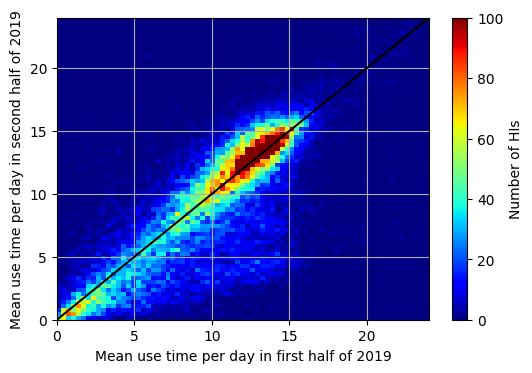

In [51]:

H1 = np.array(H1)
H2 = np.array(H2)
ok_idx = np.logical_and(H1>0, H2>0)
H1 = H1[ok_idx]
H2 = H2[ok_idx]

plt.figure(dpi = 100)
plt.hist2d(H1, H2, 75, [[0, 24], [0, 24]], cmap=plt.cm.get_cmap('jet'), vmax = 100)
cbar = plt.colorbar()
cbar.set_label('Number of HIs')
plt.grid(True)
plt.xlabel('Mean use time per day in first half of 2019')
plt.ylabel('Mean use time per day in second half of 2019')
plt.plot([0,24],[0,24], 'k-')
plt.show(block=False)

In [61]:
len(hi_use_time_low)

5820

In [62]:
len(hi_use_time_low)
#saving low usage list as pickle 
with open('hi_id_low_usage_subjects.pkl', 'wb') as f:
   pickle.dump(hi_use_time_low, f)

In [49]:
#resample use time to weekly points
hi_items = list(sub_adls.adl_by_hi.groups)
resampled_time_series={}
Q2 = []
hi_use_time_low = []
cnt = 0
appended_df = []
for hi in hi_items:
    cnt = cnt + 1
    if (cnt % 1000 == 0):
        print("Searched " + str(cnt) + " ADLs")
    time_series = sub_adls.adl_by_hi.get_group(hi)
    time_series = time_series.set_index(pd.to_datetime(time_series['ADLRawData_CreationTime']))
    time_series = time_series.loc[~time_series.index.duplicated(keep='last')]
    time_series = time_series.sort_index()

    #compute inter-time intervals
    diff_time_series[hi] = time_series.index.to_series().diff().dt.total_seconds().div(60*60*24, \
                                                                          fill_value=0)
    
    r_time_series = time_series['ADLProperties_TotalUseTime'].diff().resample('W').sum().\
    interpolate(method = 'linear') 
    
    bin = r_time_series==0
    if bin.iloc[-1]==True:
        continue
    for i in np.arange(r_time_series.shape[0]):
        start_row = i
        replace_rows = []
        n = 0
        #print("Start row : " + str(start_row))
        while (bin[start_row] == True):
            replace_rows.append(start_row)
            start_row = start_row + 1
            n = n + 1
            #print("Replace rows : " + str(replace_rows))
        if len(replace_rows) > 0:
            bin.iloc[replace_rows] = False            
            replace_value = r_time_series.iloc[start_row] / (n+1)
            r_time_series.iloc[replace_rows] = replace_value
            r_time_series.iloc[start_row] = replace_value

    resampled_time_series[hi] = r_time_series / 7
    df1 = pd.DataFrame({'ADLRawData_HearingInstrumentId':hi,'UseTimeWeekly':resampled_time_series[hi],\
                       'InterTimeInterval':diff_time_series[hi]},index=r_time_series.index)
    
    appended_df.append(df1)
    
df_use_time_weekly = pd.concat(appended_df)   


Searched 1000 ADLs
Searched 2000 ADLs
Searched 3000 ADLs
Searched 4000 ADLs
Searched 5000 ADLs
Searched 6000 ADLs
Searched 7000 ADLs
Searched 8000 ADLs
Searched 9000 ADLs
Searched 10000 ADLs
Searched 11000 ADLs
Searched 12000 ADLs
Searched 13000 ADLs
Searched 14000 ADLs
Searched 15000 ADLs
Searched 16000 ADLs
Searched 17000 ADLs
Searched 18000 ADLs
Searched 19000 ADLs
Searched 20000 ADLs
Searched 21000 ADLs
Searched 22000 ADLs
Searched 23000 ADLs
Searched 24000 ADLs
Searched 25000 ADLs
Searched 26000 ADLs
Searched 27000 ADLs
Searched 28000 ADLs
Searched 29000 ADLs
Searched 30000 ADLs
Searched 31000 ADLs
Searched 32000 ADLs
Searched 33000 ADLs
Searched 34000 ADLs
Searched 35000 ADLs
Searched 36000 ADLs
Searched 37000 ADLs
Searched 38000 ADLs
Searched 39000 ADLs
Searched 40000 ADLs
Searched 41000 ADLs
Searched 42000 ADLs


In [50]:
#saving all the new and original dataframes for further processing
sub_ADL.to_pickle('sub_ADL.pkl')
df_use_time_weekly.to_pickle('UseTime_resampled.pkl')


In [51]:
df_use_time_weekly.index

DatetimeIndex(['2019-01-27 00:00:00+00:00', '2019-02-03 00:00:00+00:00',
               '2019-02-10 00:00:00+00:00', '2019-02-17 00:00:00+00:00',
               '2019-02-24 00:00:00+00:00', '2019-03-03 00:00:00+00:00',
               '2019-03-10 00:00:00+00:00', '2019-03-17 00:00:00+00:00',
               '2019-03-24 00:00:00+00:00', '2019-03-31 00:00:00+00:00',
               ...
               '2019-12-29 00:00:00+00:00', '2020-01-05 00:00:00+00:00',
               '2020-01-12 00:00:00+00:00', '2020-01-19 00:00:00+00:00',
               '2020-01-26 00:00:00+00:00', '2020-02-02 00:00:00+00:00',
               '2020-02-09 00:00:00+00:00', '2020-02-16 00:00:00+00:00',
               '2020-02-23 00:00:00+00:00', '2020-03-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='ADLRawData_CreationTime', length=3286829, freq=None)

In [63]:
#define columns to resample 
colmn = [                           
                               'ADLProperties_TotalUseTime',
                               'ADLProperties_UseTimeInPhoneStreaming',
                               'ADLProperties_TotalUseTimeInCharger',                               
                               'ADLProperties_Bass3StateHistogram_0',
                               'ADLProperties_Bass3StateHistogram_1',
                               'ADLProperties_Bass3StateHistogram_2',
                               'ADLProperties_Bass3StateHistogram_3',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_0',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_1',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_2',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_3',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_4',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_5',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_6',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_0',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_1',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_2',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_3',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_4',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_5',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_6',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_0',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_1',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_2',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_3',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_4',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_5',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_2_6',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_0',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_1',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_2',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_3',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_4',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_5',
                               'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_3_6',
                               'ADLProperties_HistogramOnInputPowerPreset1_0',
                               'ADLProperties_HistogramOnInputPowerPreset1_1',
                               'ADLProperties_HistogramOnInputPowerPreset1_2',
                               'ADLProperties_HistogramOnInputPowerPreset1_3',
                               'ADLProperties_HistogramOnInputPowerPreset1_4',
                               'ADLProperties_HistogramOnInputPowerPreset1_5',                               
                               'ADLProperties_UseTimePerPreset_0',
                               'ADLProperties_UseTimePerPreset_1',
                               'ADLProperties_UseTimePerPreset_2',
                               'ADLProperties_UseTimePerPreset_3',
                               'ADLProperties_UseTimePerPreset_4',
                               'ADLProperties_UseTimePerPreset_5',
                               'ADLProperties_UseTimePerPreset_6',
                               'ADLProperties_UseTimePerPreset_7'
                               ]


In [64]:
#now try to resample for all columns
hi_items = list(sub_adls.adl_by_hi.groups)
resampled_time_series={}

cnt = 0
appended_df = []
for hi in hi_items:
    cnt = cnt + 1
    if (cnt % 1000 == 0):
        print("Resampled " + str(cnt) + " ADLs")
    time_series = sub_adls.adl_by_hi.get_group(hi)
    time_series = time_series.set_index(pd.to_datetime(time_series['ADLRawData_CreationTime']))
    time_series = time_series.loc[~time_series.index.duplicated(keep='last')]
    time_series = time_series.sort_index()
    
    r_time_series = time_series[colmn].diff().resample('W').sum().\
    interpolate(method = 'linear') 
    
    for colname, col in r_time_series.iteritems():
        bin = col ==0
        if bin.iloc[-1]==True:
            continue
        for i in np.arange(col.shape[0]):
            start_row = i
            replace_rows = []
            n = 0
            #print("Start row : " + str(start_row))
            while (bin[start_row] == True):
                replace_rows.append(start_row)
                start_row = start_row + 1
                n = n + 1
                #print("Replace rows : " + str(replace_rows))
            if len(replace_rows) > 0:
                bin.iloc[replace_rows] = False            
                replace_value = col.iloc[start_row] / (n+1)
                col.iloc[replace_rows] = replace_value
                col.iloc[start_row] = replace_value

    resampled_time_series[hi] = r_time_series / 7
    df = pd.DataFrame(resampled_time_series[hi], index= r_time_series.index)
    appended_df.append(df)

df_resampled_weekly_all_colums = pd.concat(appended_df)

#save it 
df_resampled_weekly_all_colums.to_pickle('All_columns_resampled_weekly.pkl')

Resampled 1000 ADLs
Resampled 2000 ADLs
Resampled 3000 ADLs
Resampled 4000 ADLs
Resampled 5000 ADLs
Resampled 6000 ADLs
Resampled 7000 ADLs
Resampled 8000 ADLs
Resampled 9000 ADLs
Resampled 10000 ADLs
Resampled 11000 ADLs
Resampled 12000 ADLs
Resampled 13000 ADLs
Resampled 14000 ADLs
Resampled 15000 ADLs
Resampled 16000 ADLs
Resampled 17000 ADLs
Resampled 18000 ADLs
Resampled 19000 ADLs
Resampled 20000 ADLs
Resampled 21000 ADLs
Resampled 22000 ADLs
Resampled 23000 ADLs
Resampled 24000 ADLs
Resampled 25000 ADLs
Resampled 26000 ADLs
Resampled 27000 ADLs
Resampled 28000 ADLs
Resampled 29000 ADLs
Resampled 30000 ADLs
Resampled 31000 ADLs
Resampled 32000 ADLs
Resampled 33000 ADLs
Resampled 34000 ADLs
Resampled 35000 ADLs
Resampled 36000 ADLs
Resampled 37000 ADLs
Resampled 38000 ADLs
Resampled 39000 ADLs
Resampled 40000 ADLs
Resampled 41000 ADLs
Resampled 42000 ADLs
